In [59]:
import os
import pandas as pd
import xarray as xr
import glob
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import plotly.express as px
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geopy.distance import geodesic

date_string = "2024-07-01"
date_string = "2024-05-06"



In [60]:
# Read metadata to filter what we want
meta = pd.read_csv("/kfs2/projects/sfcwinds/observations/metadata_CONUS.csv")

# filter which data to read
base_dir = "/kfs2/projects/sfcwinds/observations/"
stations = meta[meta.state == "NM"].station_id.values
networks = ["*"]
years    = [date_string[:4]]

#Read observations according to filter
years = [str(y) for y in years]
all_dfs = []

for net in networks:
    for station in stations:
        for year in years:
            pattern = os.path.join(base_dir, net, station, f"{year}.parquet")
            found = glob.glob(pattern)

            for f in found:
                try:
                    df = pd.read_parquet(f)
                    # Extract station_id from the path (e.g., .../CoAgMet/HOT01/2023.parquet)
                    station_id = os.path.basename(os.path.dirname(f))  # 'HOT01'
                    df["station_id"] = station_id
                    all_dfs.append(df)
                except Exception as e:
                    print(f"Failed to read {f}: {e}")

if not all_dfs:
    print("No files found.")
else:
    print(f"{len(all_dfs)} files found.")
    obs = pd.concat(all_dfs, ignore_index=True)
    obs["timestamp"] = obs["timestamp"].dt.tz_convert(None)

# Merge with metadata
obs = obs.merge(meta[["station_id", "lat", "lon", "height", "elev", "source_network", "state"]], on="station_id", how="left")

144 files found.


In [61]:
# Load ERA5 files


ERA5_folder = "/kfs2/projects/sfcwinds/ERA5"
file_pattern = os.path.join(ERA5_folder, f"ERA5_surface_{date_string[:].replace("-", "_")}*.nc")

# List of all files
file_list = sorted(glob.glob(file_pattern))

if file_list:
    
    # Read files in list
    era5 = xr.open_mfdataset(file_list[:], concat_dim ="valid_time",combine='nested', parallel = True)

    # Drop coordinates that have only one coordinate 
    # ERA5T data (temporary): expver=0005, ERA5 data (final): expver=0001.
    # number: ensemble member ( only one with deterministic forecast?)
    era5 = era5.drop_vars(['expver', 'number'])#.drop_dims(["valid_time"])


else:
    era5 = xr.Dataset()
    print ("No ERA5 data found.")

# era5 = era5.assign_coords(
#     longitude=((era5.longitude + 180) % 360) - 180
# )

era5["wspd10"] = (era5.u10**2 + era5.v10**2)**0.5


In [57]:
# Load ERA5-Land files

ERA5_folder = "/kfs2/projects/sfcwinds/ERA5"
file_pattern = os.path.join(ERA5_folder, f"ERA5_land_{date_string[:10].replace("-", "_")}*.nc")

# List of all files
file_list = sorted(glob.glob(file_pattern))

if file_list:
    
    # Read files in list
    era5l = xr.open_mfdataset(file_list[:], concat_dim ="valid_time",combine='nested', parallel = True)

    # Drop coordinates that have only one coordinate 
    # ERA5T data (temporary): expver=0005, ERA5 data (final): expver=0001.
    # number: ensemble member ( only one with deterministic forecast?)
    era5l = era5l.drop_vars(['expver', 'number'])#.drop_dims(["valid_time"])


else:
    era5l = xr.Dataset()
    print ("No ERA5 data found.")

# era5 = era5.assign_coords(
#     longitude=((era5.longitude + 180) % 360) - 180
# )

era5l["wspd10"] = (era5l.u10**2 + era5l.v10**2)**0.5


Text(0.5, 1.0, 'ERA5 land on 2024-05-06T20:00:00.000000000')

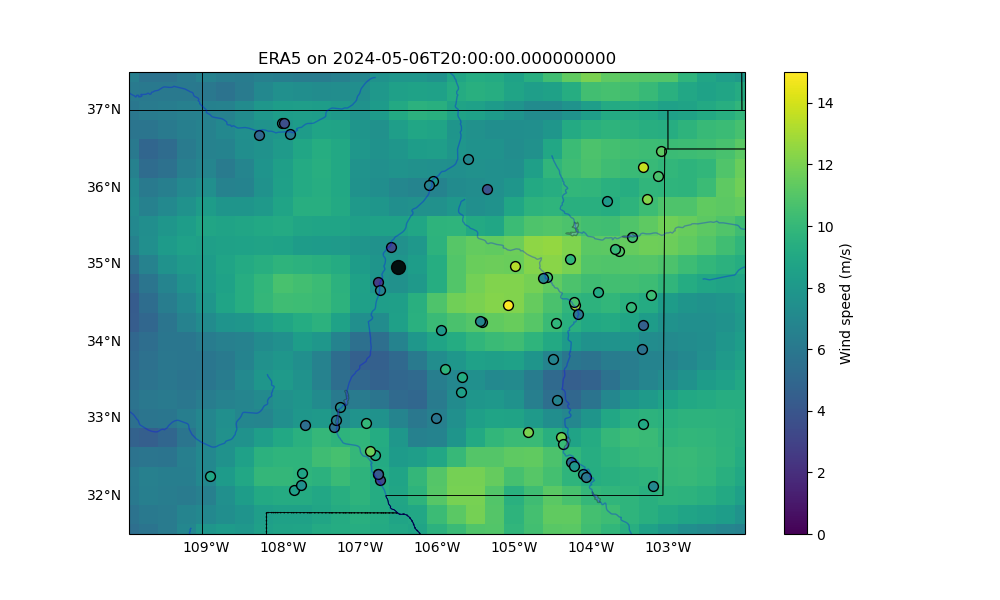

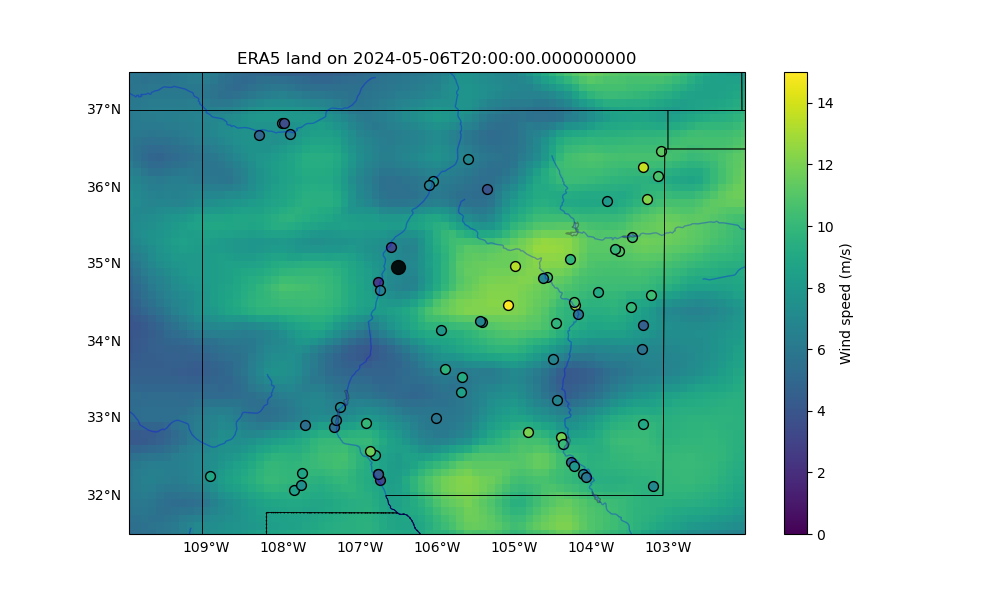

In [62]:
### Map plot on date_string

date_string = date_string[:10] + "T20:00:00.000000000"

max_wind = 15

era5_plot = era5.sel(valid_time=f"{date_string}", method='nearest')
era5l_plot = era5l.sel(valid_time=f"{date_string}", method='nearest')
obs_plot = obs[obs.timestamp == pd.to_datetime(date_string)]

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# plt.title(f"HRRR day: {hrrr_plot.time.values} \n Metar day: {metar_time}")

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle='-', linewidth=0.5, edgecolor="black") 
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=0.3)
ax.add_feature(cfeature.RIVERS, edgecolor='blue', alpha=0.3)

gl = ax.gridlines(draw_labels=True, linestyle="-", linewidth=0.5, alpha=0.0)
gl.right_labels = False  # Hide right labels
gl.top_labels = False  # Hide top labels

ax.set_extent([-110,-102, 31.5, 37.5], crs=ccrs.PlateCarree())  

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")


# ERA5 data
contour = plt.pcolormesh(era5_plot.longitude, 
                         era5_plot.latitude, 
                         era5_plot.wspd10, cmap="viridis", shading="auto", transform=ccrs.PlateCarree(), vmin = 0, vmax = max_wind)

# Obs data
for station in  np.unique(obs_plot.station_id)[:]:
    station_data = obs_plot[obs_plot.station_id == station]
    sc = plt.scatter(station_data.lon, station_data.lat, c=station_data.windspeed, cmap='viridis', s=50, edgecolor='k', vmin = 0, vmax = max_wind)

# Sandia
ax.plot(Sandia_coords[1], Sandia_coords[0],transform=ccrs.PlateCarree(), marker='o', ms=10, color='black',  alpha=0.9)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', label="Wind speed (m/s)")

# Labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title(f"ERA5 on {date_string}")

era5_plot = era5.sel(valid_time=f"{date_string}", method='nearest')
obs_plot = obs[obs.timestamp == pd.to_datetime(date_string)]

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# plt.title(f"HRRR day: {hrrr_plot.time.values} \n Metar day: {metar_time}")

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle='-', linewidth=0.5, edgecolor="black") 
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=0.3)
ax.add_feature(cfeature.RIVERS, edgecolor='blue', alpha=0.3)

gl = ax.gridlines(draw_labels=True, linestyle="-", linewidth=0.5, alpha=0.0)
gl.right_labels = False  # Hide right labels
gl.top_labels = False  # Hide top labels

ax.set_extent([-110,-102, 31.5, 37.5], crs=ccrs.PlateCarree())  

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")


# ERA5 data
contour = plt.pcolormesh(era5l_plot.longitude, 
                         era5l_plot.latitude, 
                         era5l_plot.wspd10, cmap="viridis", shading="auto", transform=ccrs.PlateCarree(), vmin = 0, vmax = max_wind)

# Obs data
for station in  np.unique(obs_plot.station_id)[:]:
    station_data = obs_plot[obs_plot.station_id == station]
    sc = plt.scatter(station_data.lon, station_data.lat, c=station_data.windspeed, cmap='viridis', s=50, edgecolor='k', vmin = 0, vmax = max_wind)

# Sandia
ax.plot(Sandia_coords[1], Sandia_coords[0],transform=ccrs.PlateCarree(), marker='o', ms=10, color='black',  alpha=0.9)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', label="Wind speed (m/s)")

# Labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title(f"ERA5 land on {date_string}")
    
    